 # Note:
 ## I generally use the terminology WPA (win probability added) instead of xMPA (expected match points added) in this notebook because I didn't think of the xMPA name until later on

In [1]:
#import some stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from tqdm import tqdm
import glob
import time
import xgboost as xgb
from sklearn.model_selection import train_test_split #use this?
from scipy import stats
from sklearn.metrics import log_loss, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import GridSearchCV

In [2]:
urlScout = 'https://raw.githubusercontent.com/bigdatacup/Big-Data-Cup-2021/main/hackathon_scouting.csv'
urlWomen = 'https://raw.githubusercontent.com/bigdatacup/Big-Data-Cup-2021/main/hackathon_womens.csv'
dataScout = pd.read_csv(urlScout)
dataWomen = pd.read_csv(urlWomen)

In [45]:
dataScoutxG = pd.read_csv('dataScoutwithxG.csv')

In [46]:
pd.set_option('display.max_columns', None)

In [47]:
dataScoutxG.head(1)

Unnamed: 0   game_date    Home Team       Away Team  Period  Clock  \
0           0  2019-09-20  Erie Otters  Sudbury Wolves       1  20:00   

   Home Team Skaters  Away Team Skaters  Home Team Goals  Away Team Goals  \
0                  5                  5                0                0   

             Team        Player        Event  X Coordinate  Y Coordinate  \
0  Sudbury Wolves  Blake Murray  Faceoff Win           100            43   

   Detail 1 Detail 2 Detail 3 Detail 4         Player 2  X Coordinate 2  \
0  Forehand      NaN      NaN      NaN  Connor Lockhart             NaN   

   Y Coordinate 2        xG  
0             NaN  0.008866

In [48]:
def getWPAready(df):
    df = df.copy()
    df['TimeLeft'] = df.apply(lambda row: (20*(3 - float(row['Period'])))*(float(row['Clock'].split(':')[0]) * 60 + float(row['Clock'].split(':')[1])),axis=1)
    df['HomeExtraGoals'] = df['Home Team Goals'] - df['Away Team Goals']
    df['HomexG'] = df.apply(lambda row: row['xG'] if (row['Team'] == row['Home Team']) else (-1*row['xG']),axis=1)
    df['NextEventGameChange'] = (df['game_date'] != df['game_date'].shift(-1))
    HomeWinDic = {}
    finalEvents = df.loc[df['NextEventGameChange']]
    for i in range(len(finalEvents)):
        row = finalEvents.iloc[i]
        if (row['Home Team Goals'] < row['Away Team Goals']):
            HomeWinDic[row['game_date']] = 0
        elif (row['Home Team Goals'] == row['Away Team Goals']):
            HomeWinDic[row['game_date']] = 1
        else:
            HomeWinDic[row['game_date']] = 2
    df['HomeWin'] = df['game_date'].map(HomeWinDic)
    df = df[['TimeLeft','HomeExtraGoals','HomexG','HomeWin']]
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    return X,y

# Create the WP model

In [49]:
X,y = getWPAready(dataScoutxG)

In [186]:
print("Overall Mean:", y.mean())
#get train/test split ready

Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.25,random_state=8) #can add shuffle=False to not shuffle

#train the xgboost model
dtrain = xgb.DMatrix(Xtrain,label=ytrain)

# XGBoost model
nrounds = 560 #use gridSearchCV
params = {
    'objective': 'multi:softprob',
    'num_class': 3,
    'booster' : 'gbtree', #gblinear/gbtree?
    'eval_metric' : ['logloss'],
    'eta' : 0.01,
    'gamma' : 3,
    'subsample' : 0.8,
    'colsample_bytree' : 0.8,
    'max_depth': 4,
    'min_child_weight' : 8#,
    #'base_score' : ytrain.mean()
}

wp_model = xgb.train(params, dtrain, num_boost_round=nrounds, verbose_eval=2)
# save for debug
wp_model.save_model('xMP.json')

Overall Mean: 0.8259987083679307


In [154]:
#test the model

dtest = xgb.DMatrix(Xtest,label=ytest)
wp_predictions = wp_model.predict(dtest) #.tolist()
#print('time to test model is ',time.time() - start_time)

In [155]:
preds0,preds1,preds2 = wp_predictions[:,0],wp_predictions[:,1],wp_predictions[:,2]
XtestCopy = Xtest.copy()
XtestCopy['xHomeLose'] = preds0
XtestCopy['xHomeTie'] = preds1
XtestCopy['xHomeWin'] = preds2
#Home team gets 2 points for win, 1 for tie, 0 for loss
XtestCopy['xHomePointsWon'] = XtestCopy.apply(lambda row: row['xHomeTie'] + 2*row['xHomeWin'],axis=1)
print('xHomePoints Mean vs. actual mean')
print(XtestCopy['xHomePointsWon'].mean())
print(ytest.mean())

xHomePoints Mean vs. actual mean
0.8257611414531137
0.8231324793083452


# Apply the model to the entire dataset and get xMPA

In [156]:
allData = xgb.DMatrix(X)
allDatawp_predictions = wp_model.predict(allData) #.tolist()

preds0,preds1,preds2 = allDatawp_predictions[:,0],allDatawp_predictions[:,1],allDatawp_predictions[:,2]
XCopy = X.copy()
XCopy['xHomeLose'] = preds0
XCopy['xHomeTie'] = preds1
XCopy['xHomeWin'] = preds2
#Home team gets 2 points for win, 1 for tie, 0 for loss
XCopy['xHomePointsWon'] = XCopy.apply(lambda row: row['xHomeTie'] + 2*row['xHomeWin'],axis=1)
print('xHomePoints Mean vs. actual mean')
print(XCopy['xHomePointsWon'].mean())
print(y.mean())

xHomePoints Mean vs. actual mean
0.8256656042579882
0.8259987083679307


In [157]:
df = dataScoutxG.copy()
XCopy = XCopy[['xHomePointsWon']]
df = df.merge(XCopy,how='left',left_index=True,right_index=True)

In [158]:
def getWPA(df):
    df = df.copy()
    df['WPA'] = df['xHomePointsWon'].shift(-1) - df['xHomePointsWon']
    #now change it for away team 
    df['WPA'] = df.apply(lambda row: row['WPA'] if (row['Team'] == row['Home Team']) else -1*row['WPA'],axis=1)
    #change start of game to 0 WPA added
    df['LastOfGame'] = (df['game_date'] != df['game_date'].shift(-1))
    df['WPA'] = df.apply(lambda row: 0 if (row['LastOfGame']) else row['WPA'],axis=1)
    return df

In [159]:
wpadf = getWPA(df)

In [169]:
avgPlayWPA = wpadf['WPA'].mean()
OttersWpa = wpadf.loc[wpadf['Team'] == 'Erie Otters'].copy()
OttersWpa = OttersWpa[['Player','WPA']]
OttersWpa['WPA'] = OttersWpa.apply(lambda row: row['WPA'] - avgPlayWPA,axis=1)
playersAvg = OttersWpa.groupby(by=['Player']).mean()
playersAvg = playersAvg.rename(columns={'WPA':'xMPAOverAvg/play'})
playersAvg = playersAvg.sort_values(by='xMPAOverAvg/play',ascending=False)
playersAvg

xMPAOverAvg/play
Player                              
Aidan Campbell              0.004621
Jamie Drysdale              0.003542
Daniel Murphy               0.002640
Luke Beamish                0.002327
Chad Yetman                 0.001974
Drew Hunter                 0.001697
Jacob Golden                0.001646
Kurtis Henry                0.001207
Kyen Sopa                   0.000997
Daniel D'Amato              0.000491
Cameron Morton              0.000262
Jack Duff                   0.000104
Maxim Golod                -0.000395
Danial Singer              -0.000621
Noah Sedore                -0.000940
Brendan Kischnick          -0.000941
Brendan Hoffmann           -0.001149
Matthew MacDougall         -0.001393
Austen Swankler            -0.001474
Brendan Sellan             -0.001518
Emmett Sproule             -0.001804
Alex Gritz                 -0.002155
Elias Cohen                -0.002213
Connor Lockhart            -0.002373
Hayden Fowler              -0.002988
Christian Kyrou            -0.003047
Brett Bressette            -0.004831

In [171]:
playersSum = OttersWpa.groupby(by=['Player']).sum()
playersSum = playersSum.sort_values(by='WPA',ascending=False)
avgWPA = playersSum['WPA'].mean()
playersSum['WPA'] = playersSum.apply(lambda row: row['WPA'] - avgWPA,axis=1)
playersSum = playersSum.rename(columns={'WPA':'TotalWPAOverAvg'})
playersSum

TotalWPAOverAvg
Player                             
Jamie Drysdale             9.634335
Chad Yetman                5.420050
Jacob Golden               3.475241
Kurtis Henry               2.938632
Drew Hunter                2.725366
Aidan Campbell             1.735000
Daniel Murphy              1.433301
Luke Beamish               1.392503
Daniel D'Amato             0.729122
Kyen Sopa                  0.643325
Cameron Morton             0.217914
Jack Duff                  0.141211
Alex Gritz                -0.368474
Brett Bressette           -0.450850
Danial Singer             -0.502043
Brendan Kischnick         -0.706925
Matthew MacDougall        -0.770887
Noah Sedore               -0.785908
Christian Kyrou           -0.830893
Maxim Golod               -1.357406
Brendan Hoffmann          -2.011092
Elias Cohen               -2.634904
Brendan Sellan            -3.026604
Emmett Sproule            -3.581960
Austen Swankler           -3.593739
Connor Lockhart           -3.679962
Hayden Fowler             -6.184352

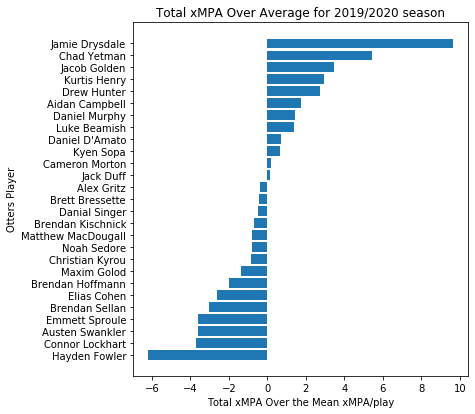

In [184]:
players = playersSum.index.unique()
y_pos = np.arange(len(players))
plt.figure(figsize=(6,6.5))
plt.barh(y_pos,playersSum['TotalWPAOverAvg'].tolist())
plt.yticks(y_pos,players)
plt.xlabel('Total xMPA Over the Mean xMPA/play')
plt.ylabel('Otters Player')
plt.gca().invert_yaxis()
plt.title('Total xMPA Over Average for 2019/2020 season')
plt.show()

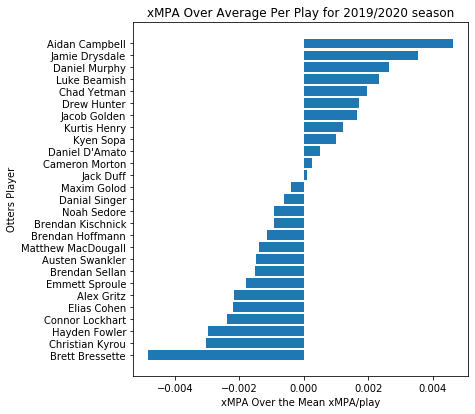

In [185]:
players = playersAvg.index.unique()
y_pos = np.arange(len(players))
plt.figure(figsize=(6,6.5))
plt.barh(y_pos,playersAvg['xMPAOverAvg/play'].tolist())
plt.yticks(y_pos,players)
plt.xlabel('xMPA Over the Mean xMPA/play')
plt.ylabel('Otters Player')
plt.gca().invert_yaxis()
plt.title('xMPA Over Average Per Play for 2019/2020 season')
plt.show()

# Some heatmaps of xG on the ice

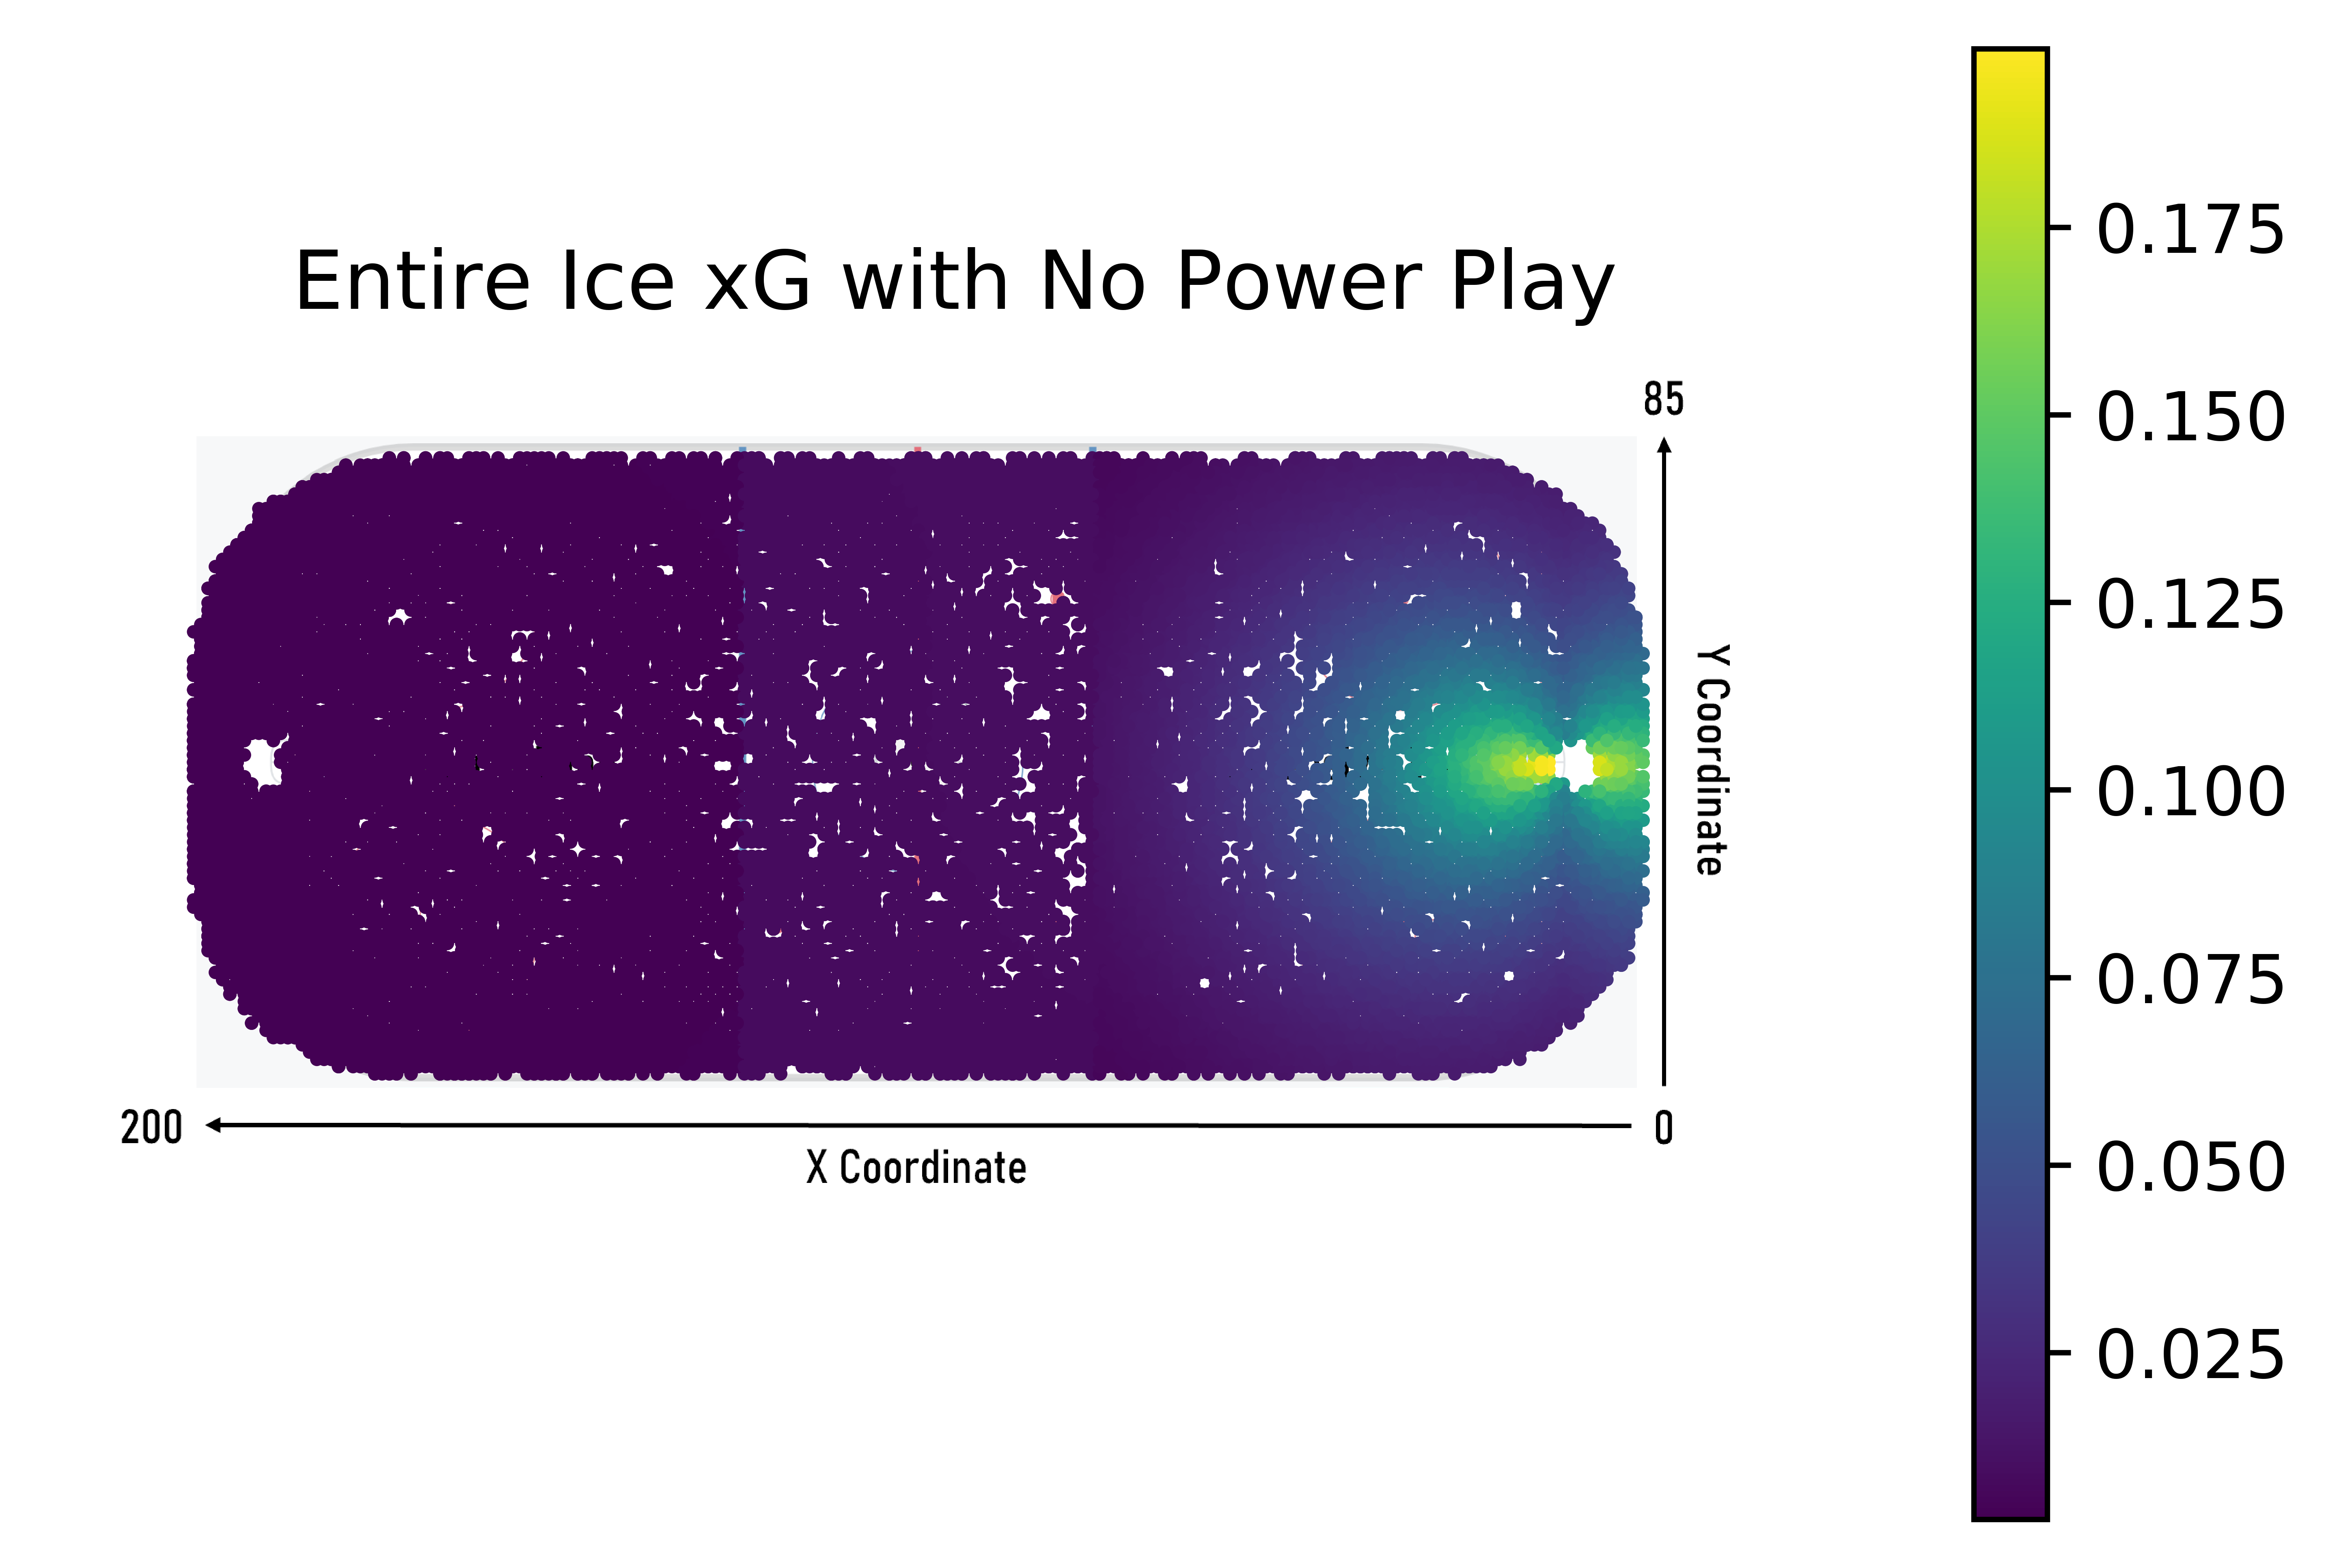

In [61]:
plotxG = dataScoutxG.loc[(dataScoutxG['Home Team Skaters'] == dataScoutxG['Away Team Skaters'])].copy()
plt.figure(dpi=1200)
plt.scatter(plotxG['X Coordinate'].tolist(),plotxG['Y Coordinate'].tolist(),c=plotxG['xG'].tolist(),s=1,cmap='viridis')
#plt.gray()
plt.colorbar()
plt.title("Entire Ice xG with No Power Play")
rinkPath = 'https://raw.githubusercontent.com/bigdatacup/Big-Data-Cup-2021/main/rink_coords.png'
im = plt.imread(rinkPath)
plt.imshow(im,extent=(-20,230,-20,100))
plt.axis('off')
plt.show()

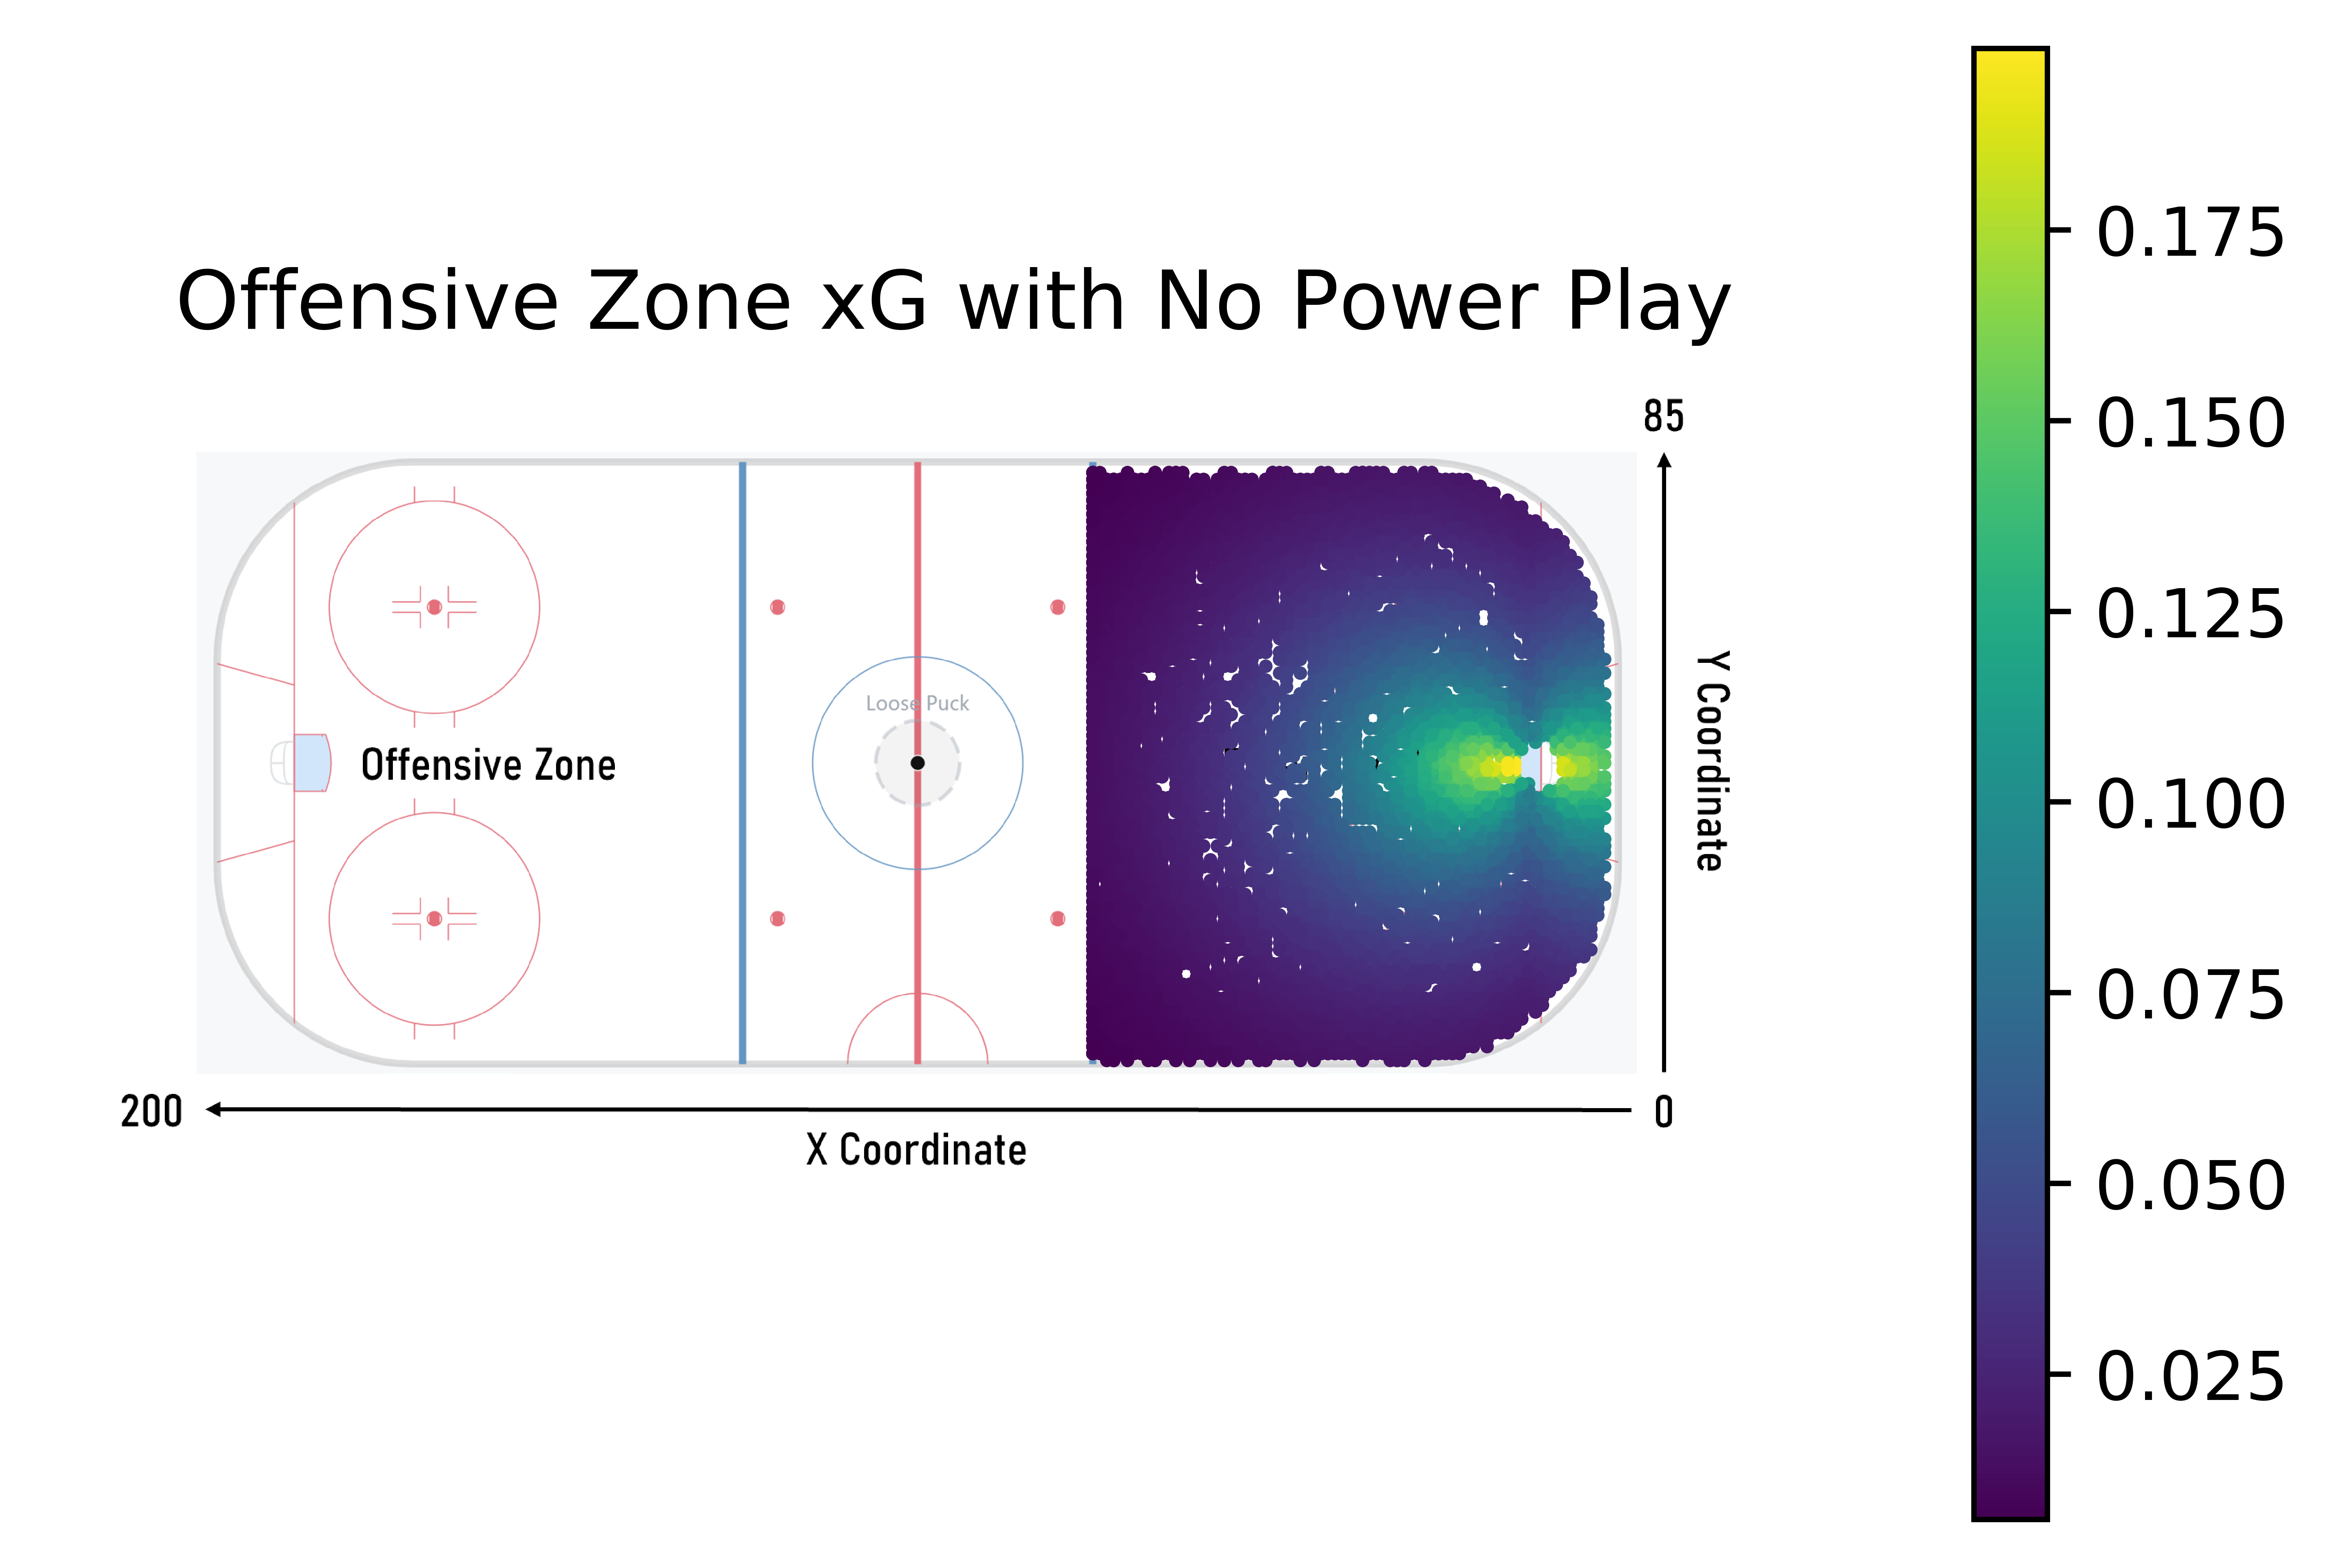

In [62]:
plotxG = dataScoutxG.loc[(dataScoutxG['Home Team Skaters'] == dataScoutxG['Away Team Skaters'])].copy()
plotxG = plotxG.loc[plotxG['X Coordinate'] > 125]
plt.figure(dpi=1200)
plt.scatter(plotxG['X Coordinate'].tolist(),plotxG['Y Coordinate'].tolist(),c=plotxG['xG'].tolist(),s=1,cmap='viridis')
#plt.gray()
plt.colorbar()
plt.title("Offensive Zone xG with No Power Play")
rinkPath = 'https://raw.githubusercontent.com/bigdatacup/Big-Data-Cup-2021/main/rink_coords.png'
im = plt.imread(rinkPath)
plt.imshow(im,extent=(-25,237,-20,100))
plt.axis('off')
plt.show()

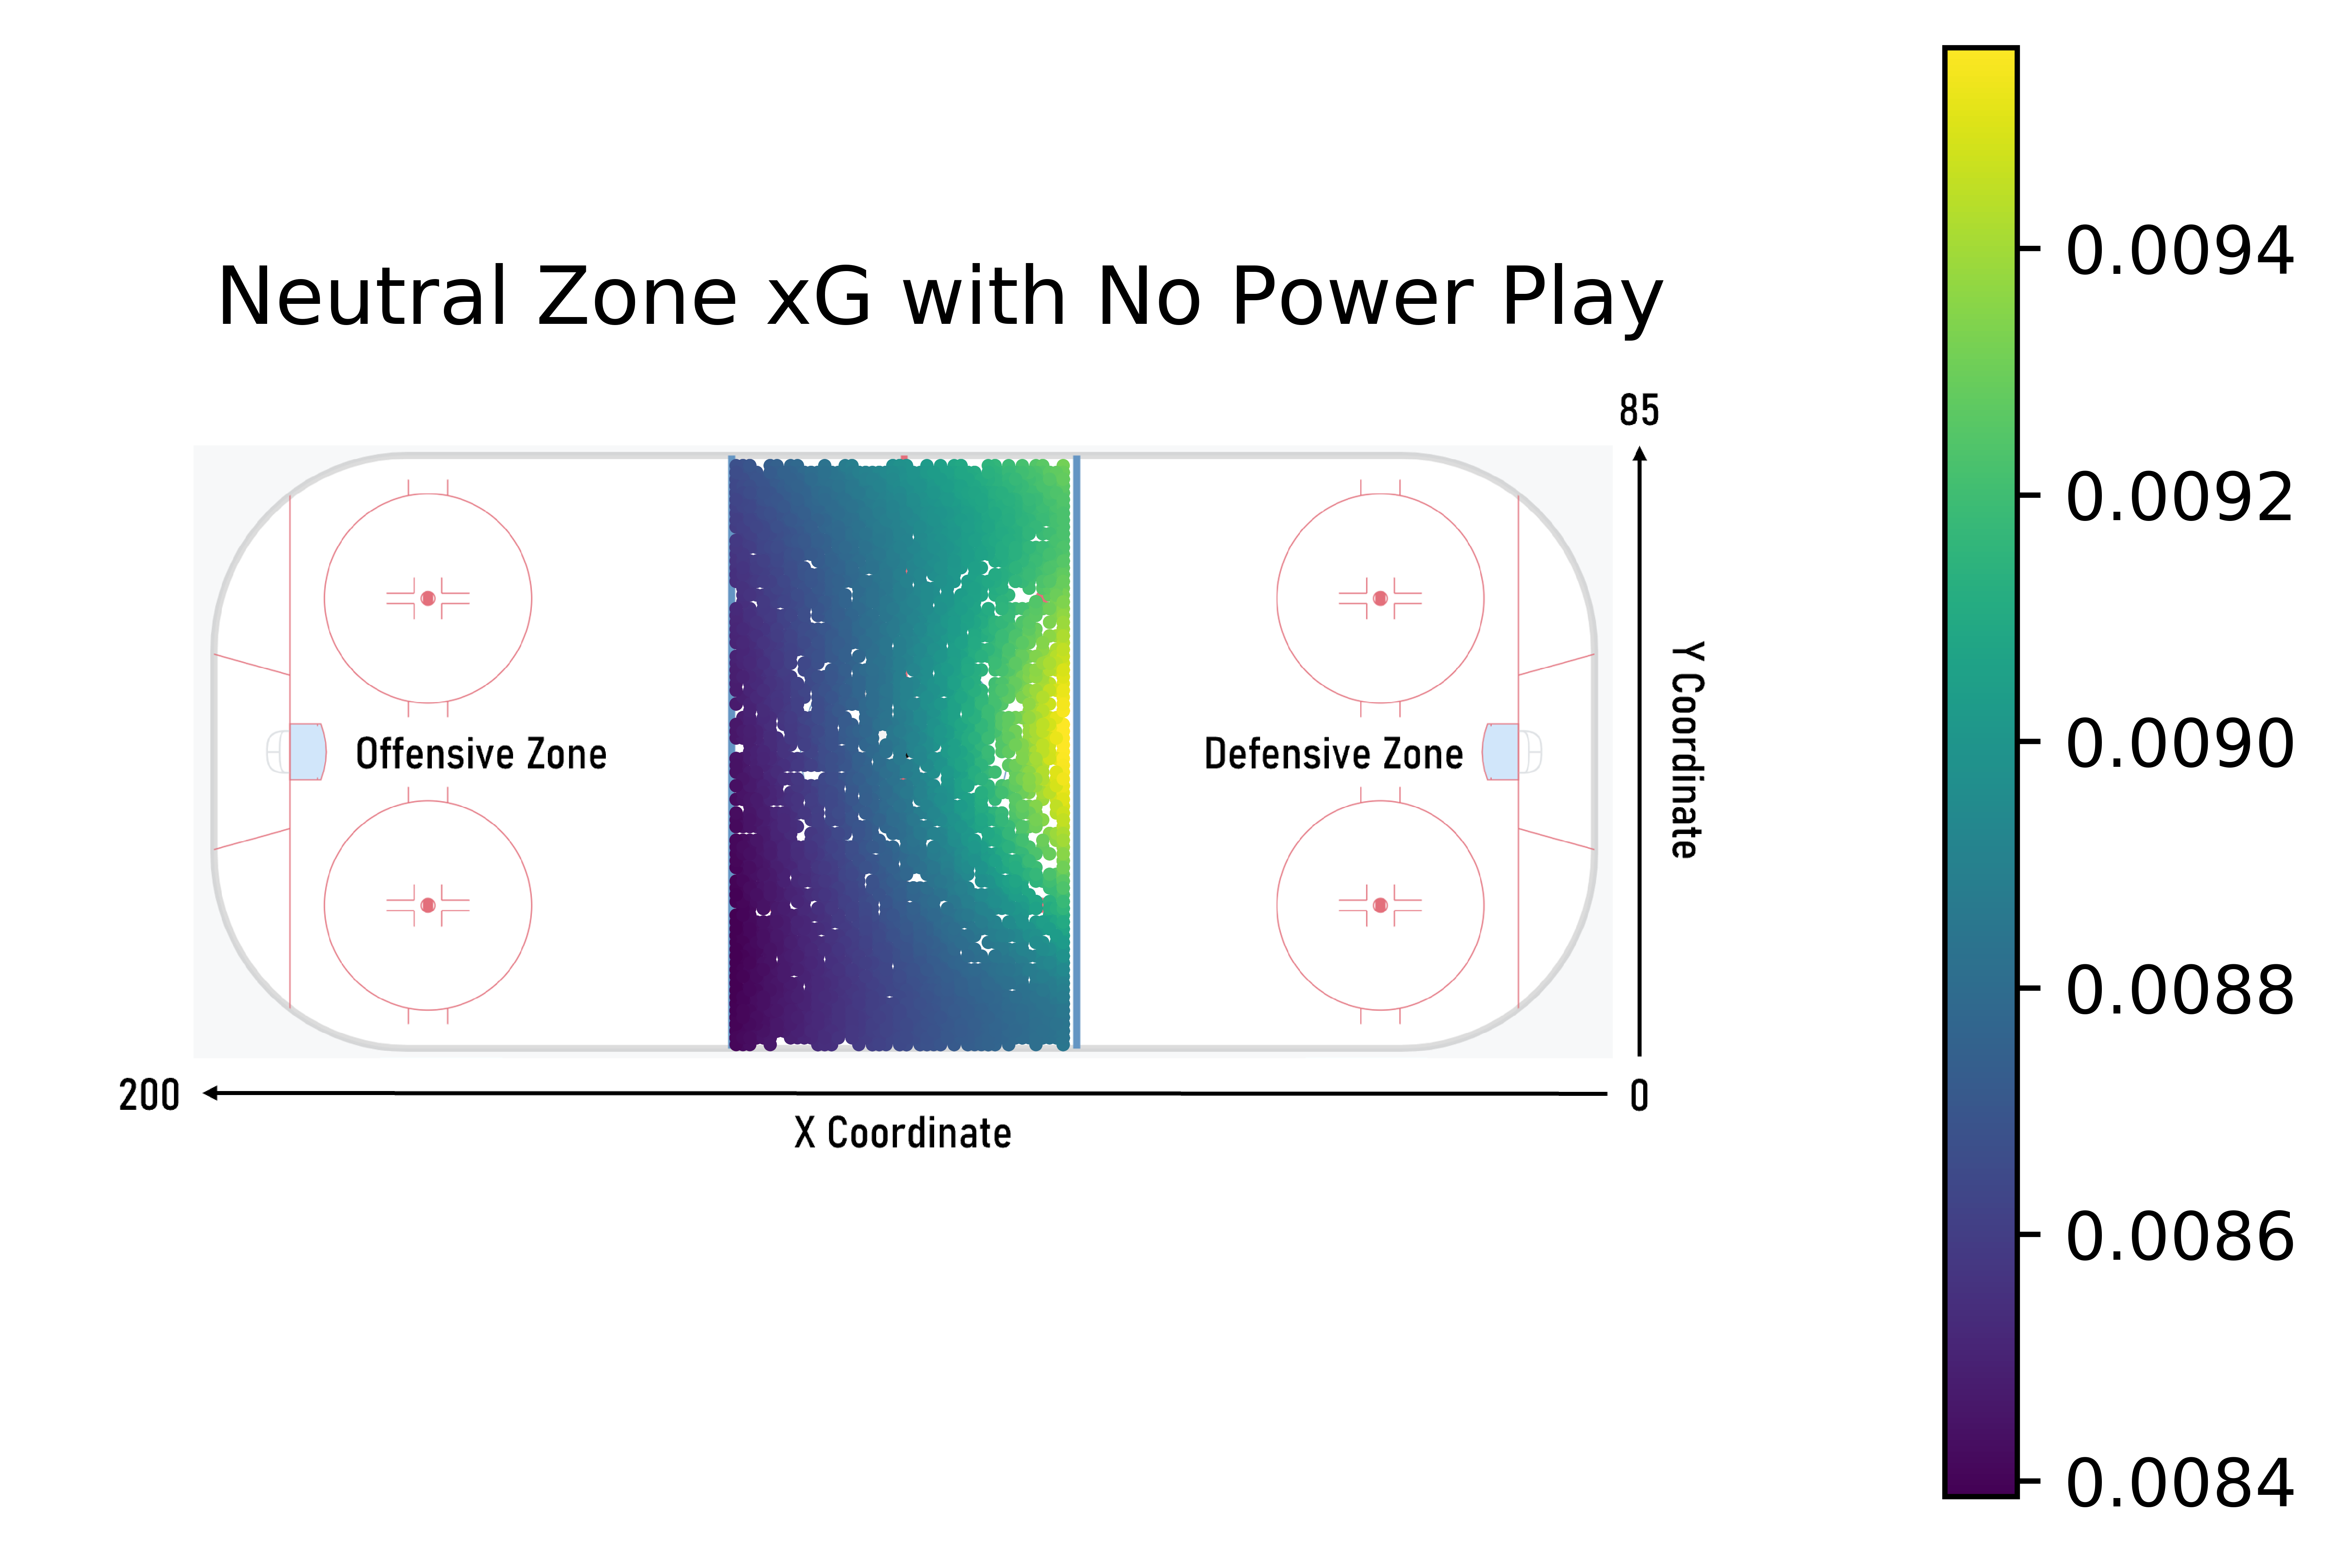

In [63]:
plotxG = dataScoutxG.loc[(dataScoutxG['Home Team Skaters'] == dataScoutxG['Away Team Skaters'])].copy()
plotxG = plotxG.loc[(plotxG['X Coordinate'] < 125) & (plotxG['X Coordinate'] > 75)]
plt.figure(dpi=1200)
plt.scatter(plotxG['X Coordinate'].tolist(),plotxG['Y Coordinate'].tolist(),c=plotxG['xG'].tolist(),s=1,cmap='viridis')
#plt.gray()
plt.colorbar()
plt.title("Neutral Zone xG with No Power Play")
rinkPath = 'https://raw.githubusercontent.com/bigdatacup/Big-Data-Cup-2021/main/rink_coords.png'
im = plt.imread(rinkPath)
plt.imshow(im,extent=(-25,237,-20,100))
plt.axis('off')
plt.show()

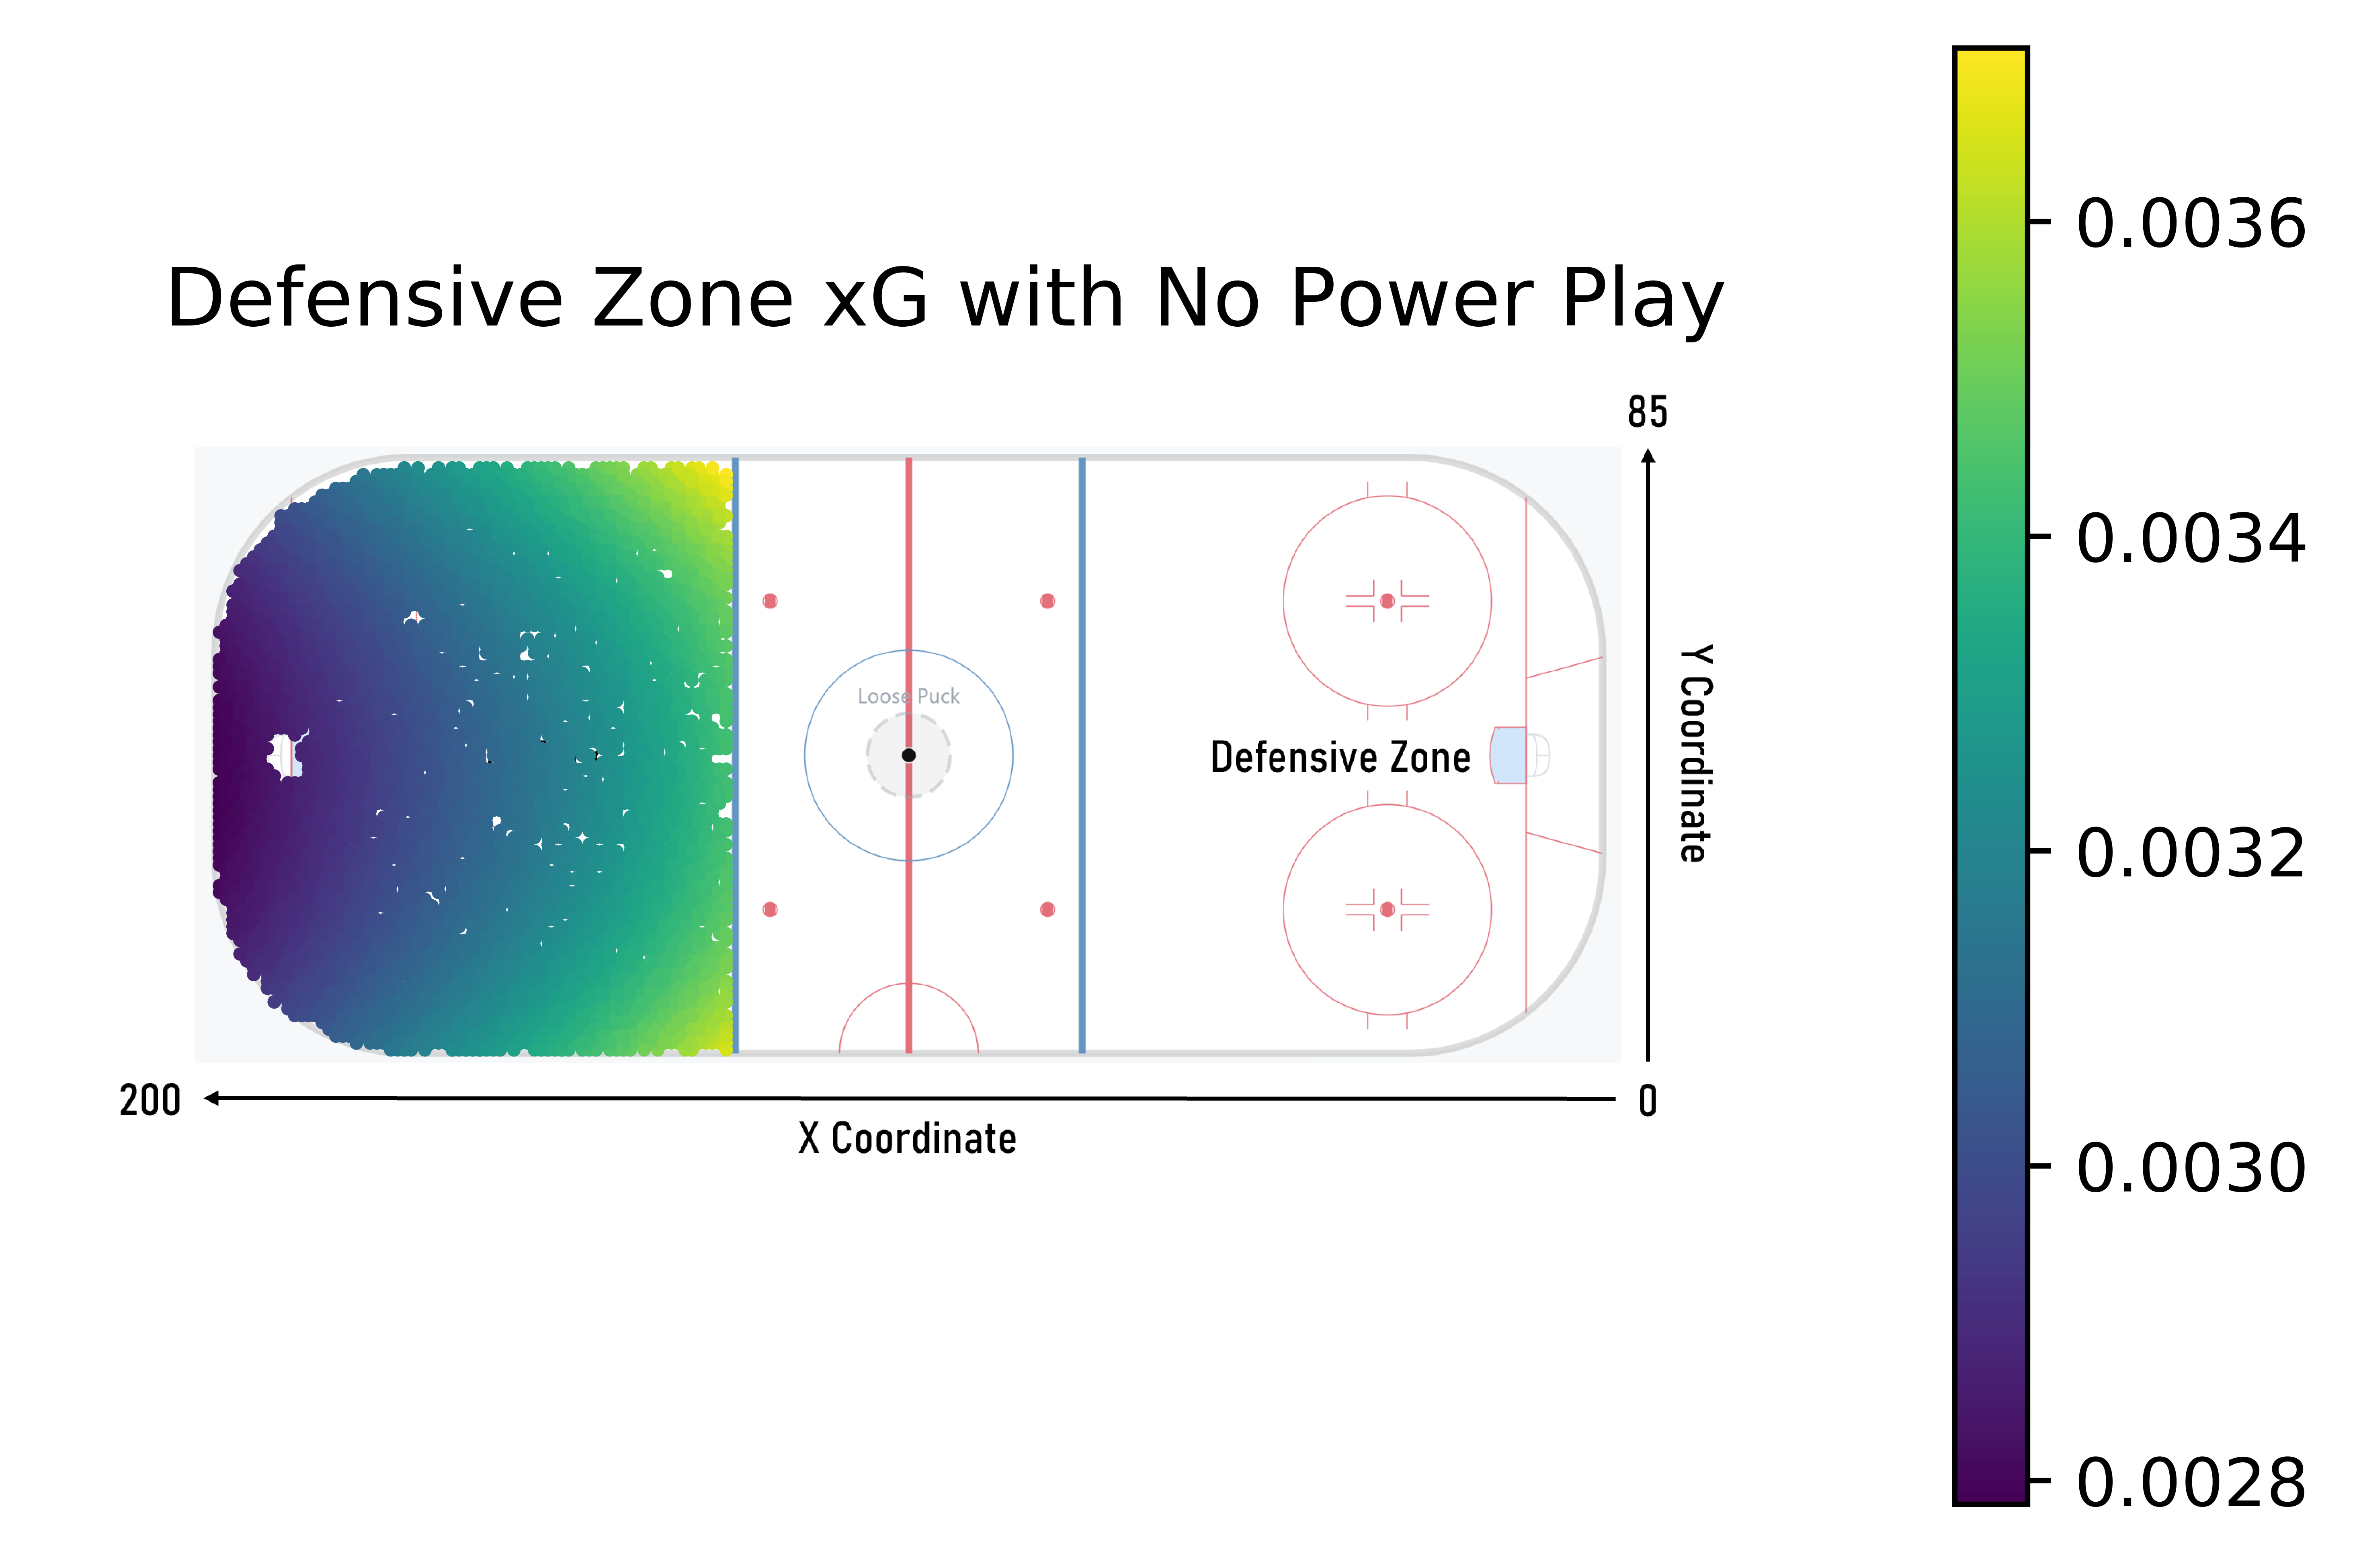

In [64]:
plotxG = dataScoutxG.loc[(dataScoutxG['Home Team Skaters'] == dataScoutxG['Away Team Skaters'])].copy()
plotxG = plotxG.loc[plotxG['X Coordinate'] < 75]
plt.figure(dpi=1200)
plt.scatter(plotxG['X Coordinate'].tolist(),plotxG['Y Coordinate'].tolist(),c=plotxG['xG'].tolist(),s=1,cmap='viridis')
#plt.gray()
plt.colorbar()
plt.title("Defensive Zone xG with No Power Play")
rinkPath = 'https://raw.githubusercontent.com/bigdatacup/Big-Data-Cup-2021/main/rink_coords.png'
im = plt.imread(rinkPath)
plt.imshow(im,extent=(-25,237,-20,100))
plt.axis('off')
plt.show()

In [44]:
dataScoutxG.loc[dataScoutxG['X Coordinate'] == 126,'xG'].mean()

0.009338964535216163